# Zillow Clustering Project

## Project Goal 
* Discover driver of log_error from the zillow database.
* Use drivers to develop machine learning model to predict log_error
* This information will be used to further our understanding of which elements contribute to or detract from a log_error.

# Imports

In [1]:
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os
import wrangle as w
import explore as e
import model as m

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

# Aquire
* Data aquired from zillow.csv file
* It contains 52442 rows and 69 features before cleaning
* Each row represents a house in the zillow dataset
* Each columns represents a feature of the house

# Prepare
###### Prepare Actions:
* Removed columns that did not contain useful information
* Renamed columns to provide readability
* Checked for null in the data
* Checked that colmn data types were appropriate
* Removed white space from values in object columns
* Encoded categorical variables
* Split data into train, validate, and test
* Scaled continous variables
* Outliers were removed

# Data Dictionary
| Feature | Definition |
|:--------|:-----------|
|fips| Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more detail|
|latitude| Latitude of the middle of the parcel multiplied by 10e6|
|longitude| Longitude of the middle of the parcel multiplied by 10e6|
|LA| fips for the LA county|
|Orange| fips for the Orange county|
|Ventura| fips for the Ventura county|
|yearbuilt| The Year the principal residence was built|
|age| The year sold, 2017, minus the yearbuilt|
|age_bin| The age of the residence divided into several bins|
|taxamount| The total property tax assessed for that assessment year|
|taxrate| The taxamount divided by tax value multiplied by 100|
|taxvalue| The total tax assessed value of the parcel|
|lot_sqft| Area of the lot in square feet|
|acres| lot_sqft divided by 43560|
|acres_bin| The acres of residence divided into several bins|
|sqft_bin| The sqft of residence divided into several bins|
|structure_dollar_per_sqft| The tax value divided by sqft|
|structure_dollar_sqft_bin| A division of the structure dollar divided into several bins|
|land_dollar_per_sqft| land_value divided by lot_sqft|
|lot_dollar_sqft_bin| land_dollar_per_sqft divided into several bins|
|bath_count| number of bathrooms in residence|
|bed_count| number of bedrooms in residence|
|bath_bed_ratio| bath_count divided by bed_count|
|cola| Whether or not a residence is in the city of LA|

In [2]:
# aquire the zillow data and looking over it
df = w.acquire_zillow()
df.head()

,parcelid,propertylandusetypeid,typeconstructiontypeid,storytypeid,airconditioningtypeid,architecturalstyletypeid,buildingclasstypeid,heatingorsystemtypeid,id,basementsqft,...,id.1,logerror,transactiondate,heatingorsystemdesc,buildingclassdesc,architecturalstyledesc,airconditioningdesc,storydesc,typeconstructiondesc,propertylandusedesc
0,14297519,261.0,NaN,NaN,NaN,NaN,NaN,NaN,1727539,NaN,...,0,0.025595,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,Single Family Residential
1,17052889,261.0,NaN,NaN,NaN,NaN,NaN,NaN,1387261,NaN,...,1,0.055619,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,Single Family Residential
2,14186244,261.0,NaN,NaN,NaN,NaN,NaN,NaN,11677,NaN,...,2,0.005383,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,Single Family Residential
3,12177905,261.0,NaN,NaN,NaN,NaN,NaN,2.0,2288172,NaN,...,3,-0.103410,2017-01-01,Central,NaN,NaN,NaN,NaN,NaN,Single Family Residential
4,12095076,261.0,NaN,NaN,1.0,NaN,NaN,2.0,781532,NaN,...,6,-0.001011,2017-01-01,Central,NaN,NaN,Central,NaN,NaN,Single Family Residential


In [3]:
# preparing the data
df = w.prepare_zillow(df)

In [4]:
# divinding fips into LA, Orange, and Ventura counties
df = e.get_counties(df)

In [5]:
#creating features
df = e.create_features(df)
df.head().T

,0,1,2,3,4
parcel_id,1.429752e+07,1.705289e+07,1.418624e+07,1.217790e+07,1.209508e+07
propertylandusetypeid,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
basement_sqft,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bath_count,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
bed_count,4.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
calc_bath_and_bed,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
decktypeid,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calc_sqft,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
finished_sqft12,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
fips,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03


In [6]:
# split data into train, validate and test dataframes
train, validate, test = w.train_validate_test_split(df)

## A brief look at the data

In [8]:
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,2832.0,2832.0,6059.0,...,0.989920,0.173049,0.2,0.6,130.530014,0.4,35.481693,0.3,0.625000,0
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,2255.0,2255.0,6059.0,...,1.036540,0.160698,0.2,0.5,75.004435,0.3,19.219286,0.2,0.625000,0
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,1563.0,1563.0,6037.0,...,1.984828,0.164256,0.2,0.4,58.162508,0.2,3.176240,0.1,1.000000,0
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,1447.0,1447.0,6059.0,...,1.802137,0.175161,0.2,0.3,32.089150,0.1,4.071429,0.1,0.666667,0
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,1415.0,1415.0,6111.0,...,1.235355,0.101079,0.1,0.3,128.823322,0.4,22.875767,0.3,0.833333,0


## A summery of the data

In [9]:
train.describe()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
count,3.545500e+04,35455.0,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,...,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000,35455.000000
mean,1.295835e+07,261.0,0.628910,2.285742,3.301283,2.285742,0.469102,1906.976082,1906.976082,6049.106840,...,1.333215,0.253902,0.167689,0.392681,89.643580,0.276796,48.017513,0.288580,0.695876,0.222536
std,2.356990e+06,0.0,29.013337,1.000827,0.921676,1.000827,5.544504,974.134960,974.134960,21.050037,...,0.567520,2.021698,0.103324,0.186141,58.575945,0.146492,70.873089,0.129067,0.239482,0.415955
min,1.071186e+07,261.0,0.000000,0.000000,1.000000,0.000000,0.000000,152.000000,152.000000,6037.000000,...,0.009372,0.005418,0.000000,0.000000,0.039833,0.000000,0.003023,0.000000,0.000000,0.000000
25%,1.152328e+07,261.0,0.000000,2.000000,3.000000,2.000000,0.000000,1266.000000,1266.000000,6037.000000,...,1.164523,0.128111,0.100000,0.300000,54.179039,0.200000,9.083754,0.200000,0.500000,0.000000
50%,1.257668e+07,261.0,0.000000,2.000000,3.000000,2.000000,0.000000,1647.000000,1647.000000,6037.000000,...,1.232293,0.156336,0.200000,0.400000,81.328826,0.300000,30.069868,0.300000,0.666667,0.000000
75%,1.412465e+07,261.0,0.000000,3.000000,4.000000,3.000000,0.000000,2280.000000,2280.000000,6059.000000,...,1.367667,0.200746,0.200000,0.500000,112.393107,0.400000,59.815905,0.400000,0.800000,0.000000
max,1.629606e+08,261.0,3560.000000,11.000000,11.000000,11.000000,66.000000,11880.000000,11880.000000,6111.000000,...,49.364739,160.032369,0.900000,0.900000,1444.221106,0.900000,1693.445000,0.900000,7.500000,1.000000


# Explore

### What is the distribution of logerror?

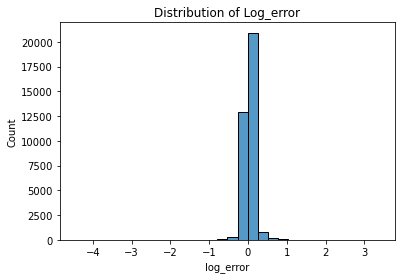

In [10]:
# get barchart of log_error
e.logerror_distribution(train)

##### The distribution of log_error is very slight and even. So most logerror is a slight difference in actual value in either the positive or negative direction.

### Is a property more likely to be over evaluated or under evaluated?

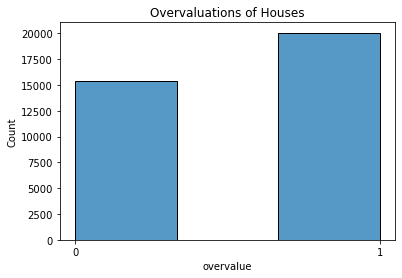

In [11]:
e.zestimate(train)

###### A property is more likely to be over evaluated then under.

# Exploration Summary
* The distribution of log_error is very slight and even
* A property is more likely to be overvalued than undervalued
* 
* 
* 

# Features we are Moving to modeling with
* 
* 
* 

# Features we are not Moving to modeling with
* 

# Modeling
* We will be using RMSE as the evaluation metric
* 
* 
* I will be evaluating models developed using four different model types and various hyperparameter configurations
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data